In [ ]:
import pandas as pd

df = pd.read_csv("data/20241123205432.csv")
df[:3]

,base,feature,steerage,question,mean_score,text
0,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,0,2.038584,2
1,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,1,2.584763,2
2,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,2,4.111586,4
3,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,3,1.545083,1
4,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,4,3.018046,2
5,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,5,1.617609,1
6,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,6,6.010261,6
7,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,7,4.910930,4
8,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.5,8,6.247510,6
9,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,-0.3,0,1.951313,2


In [ ]:
df['factor'] = df['question'].apply(lambda x: 'IB' if x%2 == 0 else 'IH')
df2 = df.drop('base', axis=1).groupby(['feature', 'steerage', 'factor'], as_index=False).mean()
df2 = df2.pivot(index=['feature', 'steerage'],columns='factor', values='mean_score').reset_index()
df2[:3]


factor,feature,steerage,IB,IH
0,Abstract moral and ethical concepts,-0.5,4.092085,2.121718
1,Abstract moral and ethical concepts,-0.3,4.166004,1.995793
2,Abstract moral and ethical concepts,-0.2,4.297176,1.996787
3,Abstract moral and ethical concepts,-0.1,4.453097,2.021997
4,Abstract moral and ethical concepts,0.0,4.648989,2.054175
5,Abstract moral and ethical concepts,0.1,4.869165,2.220305
6,Abstract moral and ethical concepts,0.2,5.074772,2.366423
7,Abstract moral and ethical concepts,0.3,5.281419,2.497518
8,Abstract moral and ethical concepts,0.5,5.783199,2.826969
9,Character acknowledging moral necessity or eth...,-0.5,6.113683,1.834009


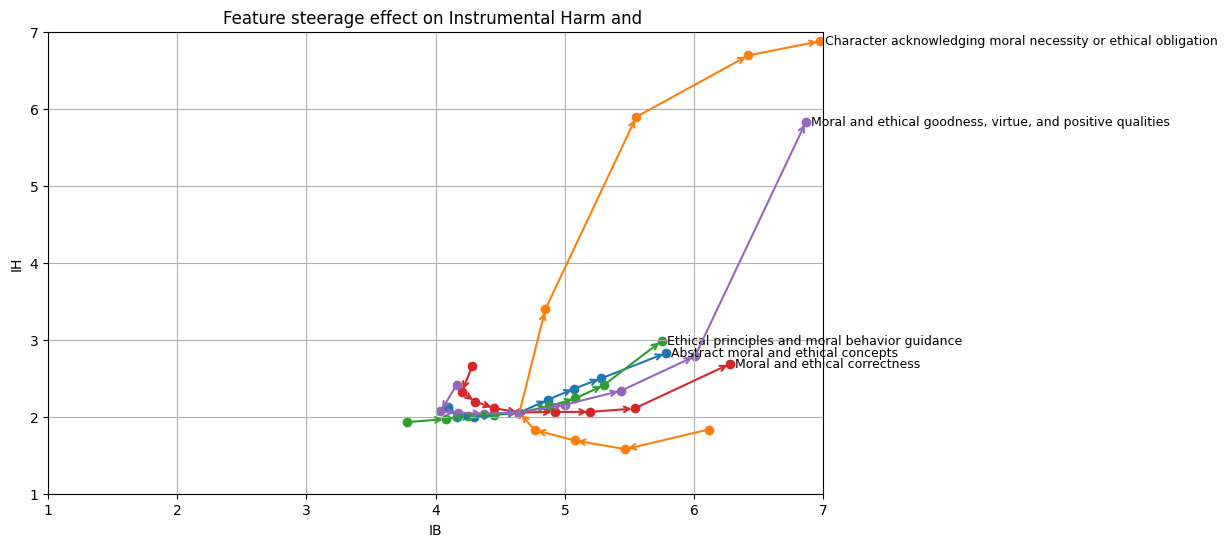

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))

def scatter_plot_feature(feature, group):
    """Group should have IB/IB and be in sorted order"""
    sc = plt.scatter(group['IB'], group['IH'],  marker='o',label=feature)
    color = sc.get_facecolor()
    for i in range(len(group) - 1):
        plt.annotate(
            '',  # No text for the annotation
            xy=(group['IB'].iloc[i + 1], group['IH'].iloc[i + 1]),  # Arrow end
            xytext=(group['IB'].iloc[i], group['IH'].iloc[i]),  # Arrow start
            arrowprops=dict(arrowstyle='->', lw=1.5, color=color),  # Arrow style
        )
    plt.text(group['IB'].iloc[-1] + 0.04, group['IH'].iloc[-1], feature, fontsize=9, ha='left', va='center')

for feature, group in df2.groupby('feature'):
    scatter_plot_feature(feature, group)

# Add labels, legend, and grid
plt.xlim(1, 7)
plt.ylim(1, 7)
plt.xticks(range(1, 8))  # Tick marks from 1 to 7
plt.yticks(range(1, 8))  # Tick marks from 1 to 7
plt.xlabel('IB')
plt.ylabel('IH')
plt.title('Feature steerage effect on Instrumental Harm and Impartial Beneficence')
plt.grid(True)

# Show plot
plt.show()